In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from nbodykit.lab import CSVCatalog, FKPCatalog, ConvolvedFFTPower

In [2]:
mock_dir = Path("/home/mikesw/Documents/Bispec/Triumvirate/storage/input/mocks/eBOSS_EZmock_QSO_NGC_v7")
dat = CSVCatalog(str(mock_dir/"EZmock_eBOSS_QSO_NGC_v7_0001_xyz_w.dat"), ['x', 'y', 'z', 'w'])
ran = CSVCatalog(str(mock_dir/"EZmock_eBOSS_QSO_NGC_v7_0001_xyz_w.ran"), ['x', 'y', 'z', 'w'])

for cat in [dat, ran]:
    cat['Position'] = cat['x'][:, None] * [1., 0., 0.] \
        + cat['y'][:, None] * [0., 1., 0.] \
        + cat['z'][:, None] * [0., 0., 1.]

In [3]:
import fitsio

dat_raw = fitsio.read(mock_dir/"EZmock_eBOSS_QSO_NGC_v7_0001.dat.fits")
ran_raw = fitsio.read(mock_dir/"EZmock_eBOSS_QSO_NGC_v7_0001.ran.fits")

In [4]:
dat['NZ'] = dat_raw['NZ']
ran['NZ'] = ran_raw['NZ']

dat['Weight'] = dat_raw['WEIGHT_NOZ'] * dat_raw['WEIGHT_CP'] * dat_raw['WEIGHT_SYSTOT']
ran['Weight'] = ran_raw['WEIGHT_NOZ'] * ran_raw['WEIGHT_CP'] * ran_raw['WEIGHT_SYSTOT']
dat['FKPWeight'] = dat_raw['WEIGHT_FKP']
ran['FKPWeight'] = ran_raw['WEIGHT_FKP']

cat = FKPCatalog(dat, ran)

In [5]:
mesh = cat.to_mesh(
    BoxSize=7000.,
    Nmesh=768,
    resampler='tsc',
    compensated=True,
    interlaced=False
)

In [6]:
results = ConvolvedFFTPower(
    mesh,
    poles=[0,]
)

/home/mikesw/anaconda3/envs/cosmo/lib/python3.8/site-packages/nbodykit/algorithms/convpower/fkp.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  xgrid = [xx.astype('f8') + offset[ii] for ii, xx in enumerate(density2.slabs.optx)]
/home/mikesw/anaconda3/envs/cosmo/lib/python3.8/site-packages/nbodykit/algorithms/convpower/fkp.py:536: ComplexWarning: Casting complex values to real discards the imaginary part
  kgrid = [kk.astype('f8') for kk in cfield.slabs.optx]


In [7]:
k_nbkt = results.poles['k'][1:]
pk_nbkt = results.poles['power_0'].real[1:]

In [8]:
_, k_trium, pk_trium, sk_trium = np.loadtxt(
    "/home/mikesw/Documents/Bispec/Triumvirate/storage/output/measurements/powspec/pk0_EZmock_eBOSS_QSO_NGC_v7",
    unpack=True
)

In [15]:
renorm = 0.26045 * results.attrs['randoms.norm']

In [23]:
print(k_nbkt[-1] * 0.8)

0.27538140195445243


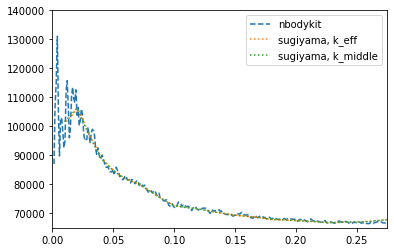

In [27]:
plt.plot(k_nbkt, pk_nbkt, ls='--', label='nbodykit')
plt.plot(k_trium, pk_trium / renorm, ls=':', label='sugiyama, k_eff')
plt.plot(_, pk_trium / renorm, ls=':', label='sugiyama, k_middle')

plt.xlim(left=0., right=0.275)
# plt.ylim(0., 12500.)
plt.ylim(65000., 140000.)
plt.legend()

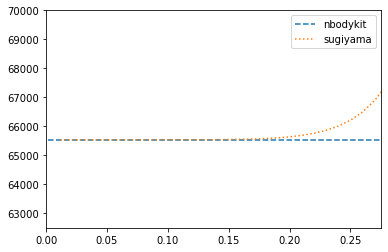

In [28]:
plt.plot(k_nbkt, results.attrs['shotnoise'] * np.ones_like(k_nbkt), ls='--', label='nbodykit')
plt.plot(k_trium, sk_trium / renorm, ls=':', label='sugiyama')

plt.xlim(0., 0.275)
plt.ylim(62500., 70000.)
plt.legend()